## Open FDA exploratory notebook



In [1]:
import requests
import os
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import time
from joblib import delayed, Parallel
import datetime
# helper functions:
import helpers
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

%matplotlib inline

### Helper functions:

In [242]:


def country_convert(s):
    
    if s =='YU':
        
        s = 'Yugoslavia'
    try:
        s = coco.convert(s, to ='short_name')
    
    except:
        pass
    
    return(s)




def days_between(d1, d2):
    
    if np.isnan(d1) or np.isnan(d2):
        
        return np.nan

    else:
    
        d1 = str(int(d1))

        d2 = str(int(d2))

    if len(d1) == 6:
        
        d1 = d1+'01'
        
    elif len(d1) == 4:
        
        d1 = d1 +'0101'
        
    if len(d2) == 6:

        d2 = d2+'01'

    elif len(d2) == 4:

        d2 = d2 +'0101'
    
    try:
        
        d1 = datetime.datetime.strptime(d1, "%Y%m%d")
        d2 = datetime.datetime.strptime(d2, "%Y%m%d")
    
        return abs((d2 - d1).days)
    except:
        return np.nan




def folium_map(data2, title = 'Rate of Life Theatening Conditions Across Countries'):
    # Make an empty map
    m = folium.Map(location=[20, 0], zoom_start=3,width=1500,height=800)
    
    title_html = '''
             <h3 align="left" style="font-size:20px"><b>''' + title + '''</b></h3>'''
    m.get_root().html.add_child(folium.Element(title_html))


    for i in range(0,len(data2)):
           folium.Circle(
              location=[data2['lat'][i], data2['lon'][i]],
              popup= data2['country'][i] + ': ' + str(round(100*data2['proportion'][i],2))+ '%',
              radius=data2['proportion'][i]*1000000,
              color='crimson',
            fill = True,
            fill_color='crimson').add_to(m)
    return m



================================================================================================================================================================================================
### Let's get a sense of the sample data:

- The sample of data we pulled has 63800 rows and 85 columns, with event dates ranging from January 2010 to March 2020. Note: the total data set consists of over 1.2 million records, so the data we are working with here is only a small representation of the complete picture

- There are quite a few columns with incomplete data, we'll need to do some data QC to select more useful features

- While some data is not missing, they may still be non-informative if e.g. there is only 1 unique value



### Read in data pulled from the API:

In [51]:
data = pd.read_csv('openFDA_data/data/combined_weekly_sample_20200515.csv');

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (10,23,29,31,41,55,62,65,66) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.shape

(63800, 81)

### How many variables are missing data?

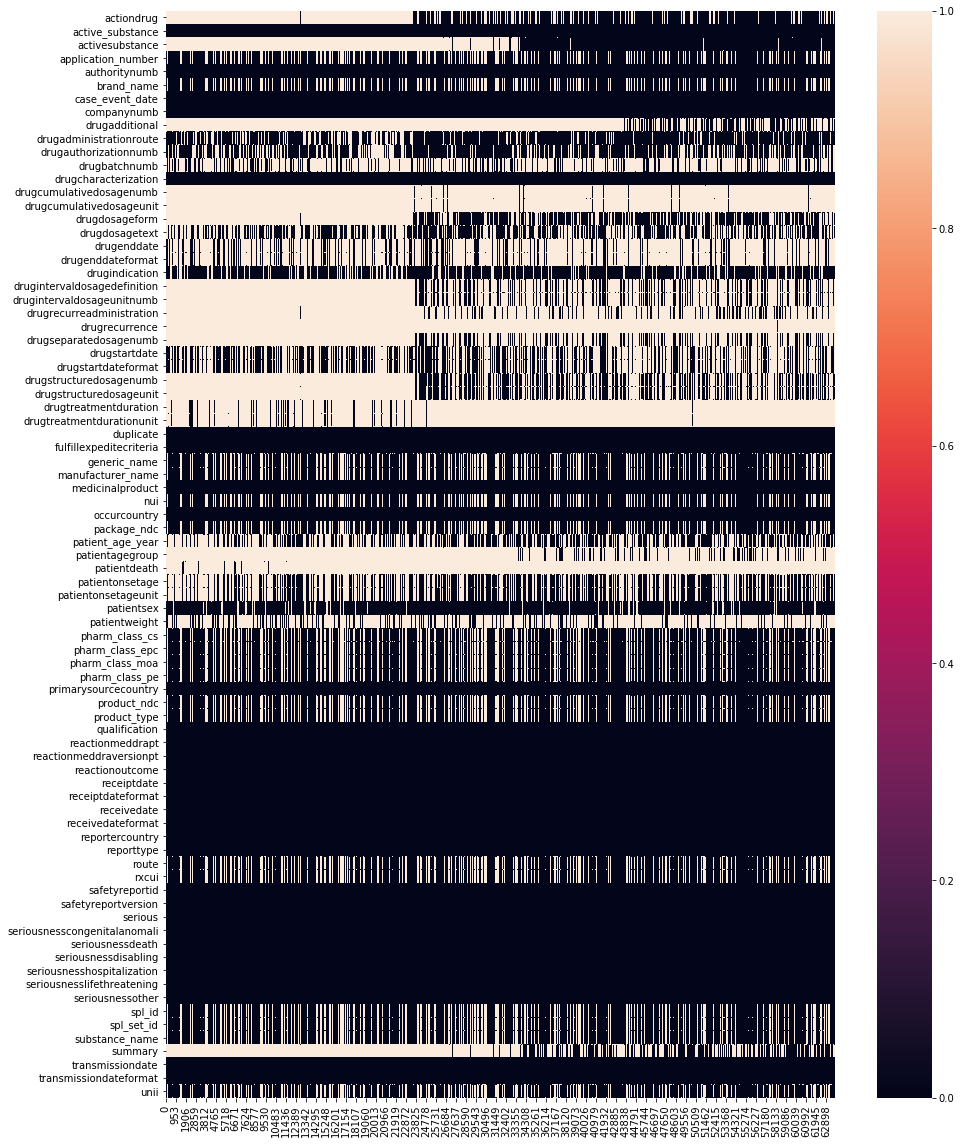

In [146]:
plt.figure(figsize=(15,20))
missing_data_count = sns.heatmap(data.isnull().transpose(), cbar = True)
plt.savefig('missing_data_count.png')
#sns.barplot(data_var)
#missing_data_count.savefig("missing_data_count.png")

### How many unique levels there are across the variables?

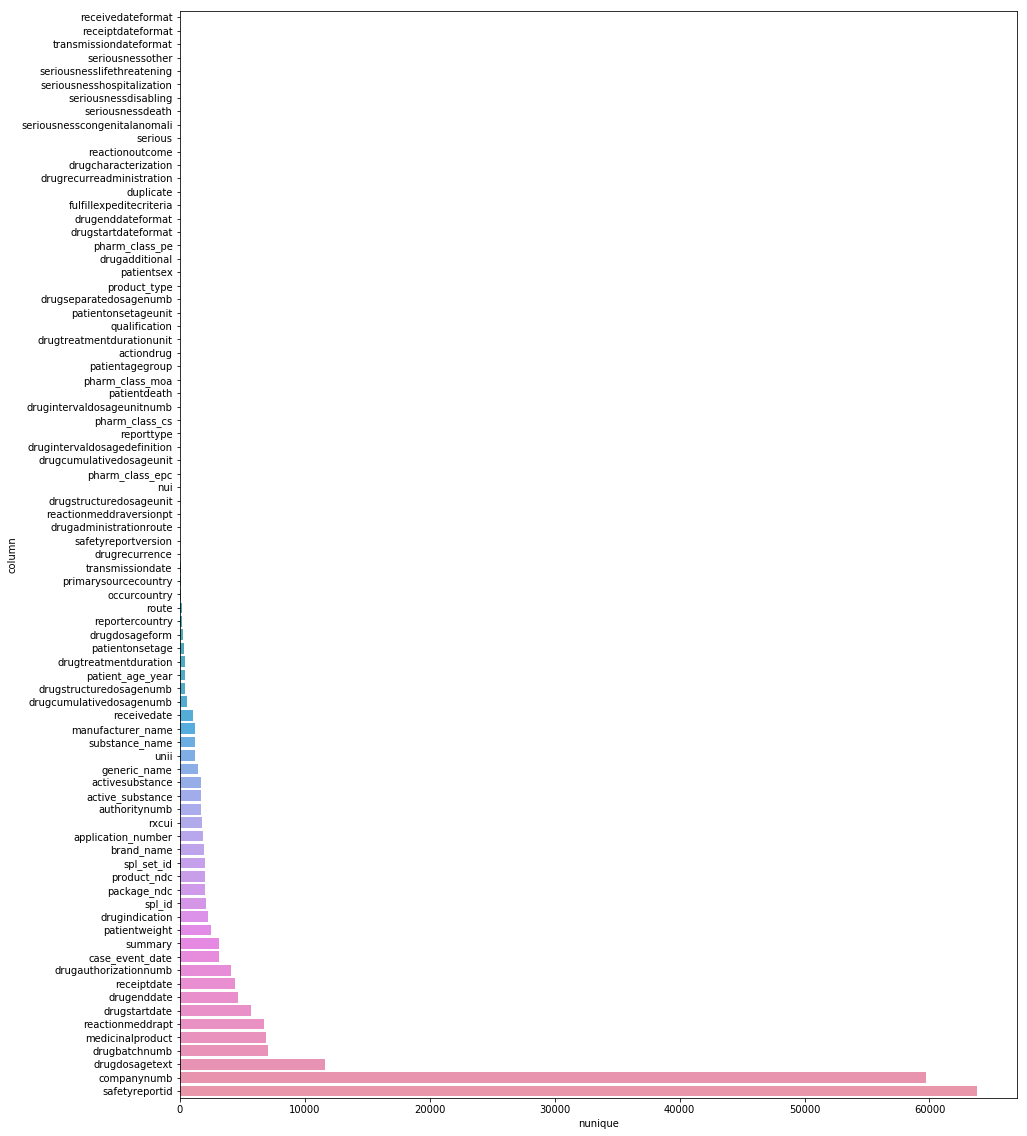

In [147]:
unique_levels = pd.DataFrame(data = {'column':data.columns,'nunique':data.nunique()}).sort_values('nunique')
plt.figure(figsize=(15,20))
sns.barplot(data=unique_levels, y ='column', x='nunique')
plt.savefig('unique_levels.png')

================================================================================================================================================================================================

### Data cleaning:

Horizontal (column): by dropping a feature using the following criteria:

- % of missing data > 80%

- has only 1 unique level

- represents a nested key (those were already unested in the previous data gathering function so information should be contained in other columns)




### Additional feature generation:

- patient age in years
- drug duration (taken as difference between `drugstartdate` and `drugenddate`, if exists
- lat and lon of reporter countries

In [ ]:

countries = data_subset['reportercountry'].unique()

countries_short = [country_convert(val) for val in countries]

country_lookup = pd.DataFrame(data = {'reportercountry':countries,'country_short':countries_short})

from geopy.geocoders import Nominatim
geolocator = Nominatim()
#import numpy as np

locs = [geolocator.geocode(c) for c in country_lookup['country_short']]

lat = [locs[i].latitude if locs[i] is not None else np.NaN for i in range(0,len(country_lookup))]
lon = [locs[i].longitude if locs[i] is not None else np.NaN  for i in range(0,len(country_lookup))]
country_lookup['lat'] = lat
country_lookup['lon'] = lon

In [477]:
missing_df = data.isnull()

missing_df_info = pd.DataFrame(data = {'missing_count':missing_df[missing_df==True].count(axis=0)/len(data)})


nested_keys = ['primarysource','sender','patient','receiver','reportduplicate','summary','patientdeath']
informative_vars1 = [val for val in set(missing_df_info[missing_df_info['missing_count']<0.8].index) - set(nested_keys) ]

informative_vars2 = [val for val in unique_levels[unique_levels['nunique']>1].index]

informative_vars = [val for val in informative_vars1  or informative_vars2]

data_subset = data[informative_vars]

data_subset['serious'] = data_subset['serious'].apply(lambda s : 1 if s ==1 else 0)

# add country information:
country_lookup = pd.read_csv('country_lookup.csv')

data_subset = data_subset.merge(country_lookup)

country_count = data_subset['country_short'].value_counts(ascending = False).reset_index()

country_count.columns = ['country_short','country_short_count']


data_subset = data_subset.merge(country_count)

drug_duration = [ days_between(data_subset['drugstartdate'][i],data_subset['drugenddate'][i]) for i in range(0,len(data_subset))]


# add drug duration:
data_subset['drug_duration'] = drug_duration


active_sub_count = data_subset['active_substance'].value_counts().reset_index()

active_sub_count.columns = ['active_substance','active_substance_count']

data_subset = data_subset.merge(active_sub_count)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [478]:
len(data_subset['patient_age_year'].dropna())

32506

### Let's take a look at the variables that got removed:

In [406]:
set(data.columns) - set(informative_vars)

{'drugadditional',
 'drugcumulativedosagenumb',
 'drugcumulativedosageunit',
 'drugrecurreadministration',
 'drugrecurrence',
 'drugtreatmentduration',
 'drugtreatmentdurationunit',
 'patientagegroup',
 'patientdeath',
 'summary'}

================================================================================================================================================================================================
## Now some data analysis to answer some high level questions:

### Overview: can we use the data to get some useful answers such as the following?


    
- **Adverse events**

    - how often do we see an adverse events reported in this sample of data?
    - how wide-spread are these adverse events across countries?
    - given they are serious adverse events, what are the main reactions associated with it?

- **Product** 

    - what type of products are there?
    - what are the most common active ingredients?
    - which products are most associated with an adverse event?
    
- **Patient**

    - what are the age and gender of the patients?
    - how long did they typically take the drug before a reaction happens?
    - what are some of the reactions associated with adverse events?
    - do we see these reactions more often in certain age group or gender?



### Types of adverse events:

Let's see the breakdown of productions by adverse events:

From the metadata, we know that the flag `serious` indicates whether or not the adverse events result in serious conditions which are: death, a life threatening condition, hospitalization, disability, congenital anomaly, and other. 



In [394]:
serious_flag = [val for val in data_subset.columns if 'serious' in val]

serious_flag

['serious',
 'seriousnesslifethreatening',
 'seriousnessdeath',
 'seriousnesshospitalization',
 'seriousnesscongenitalanomali',
 'seriousnessother',
 'seriousnessdisabling']

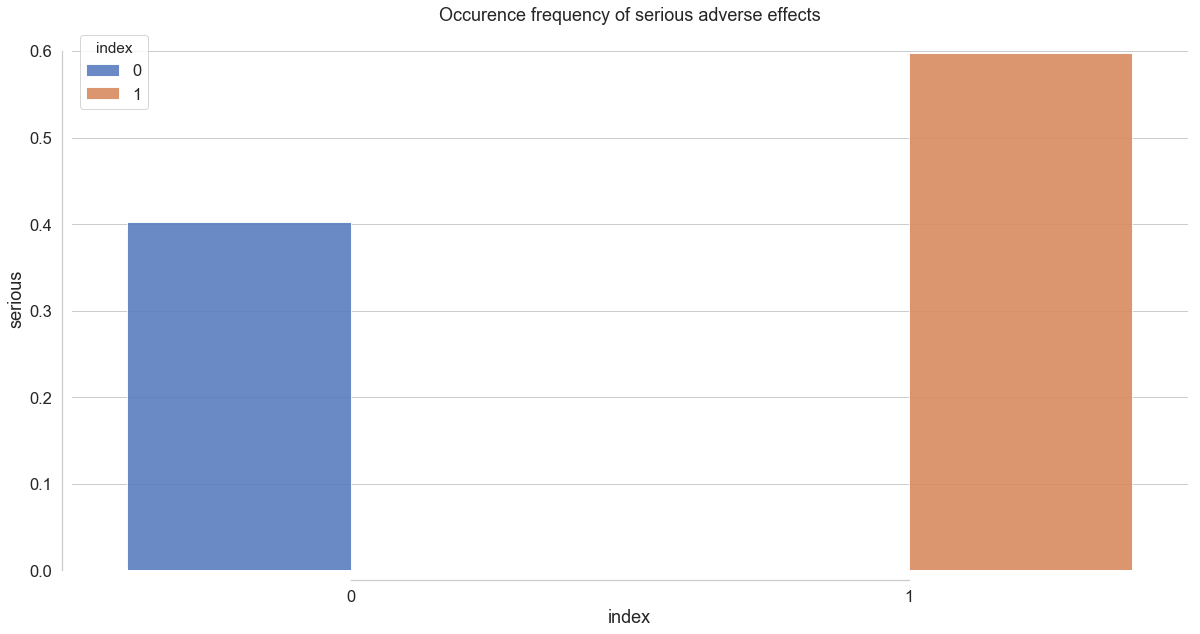

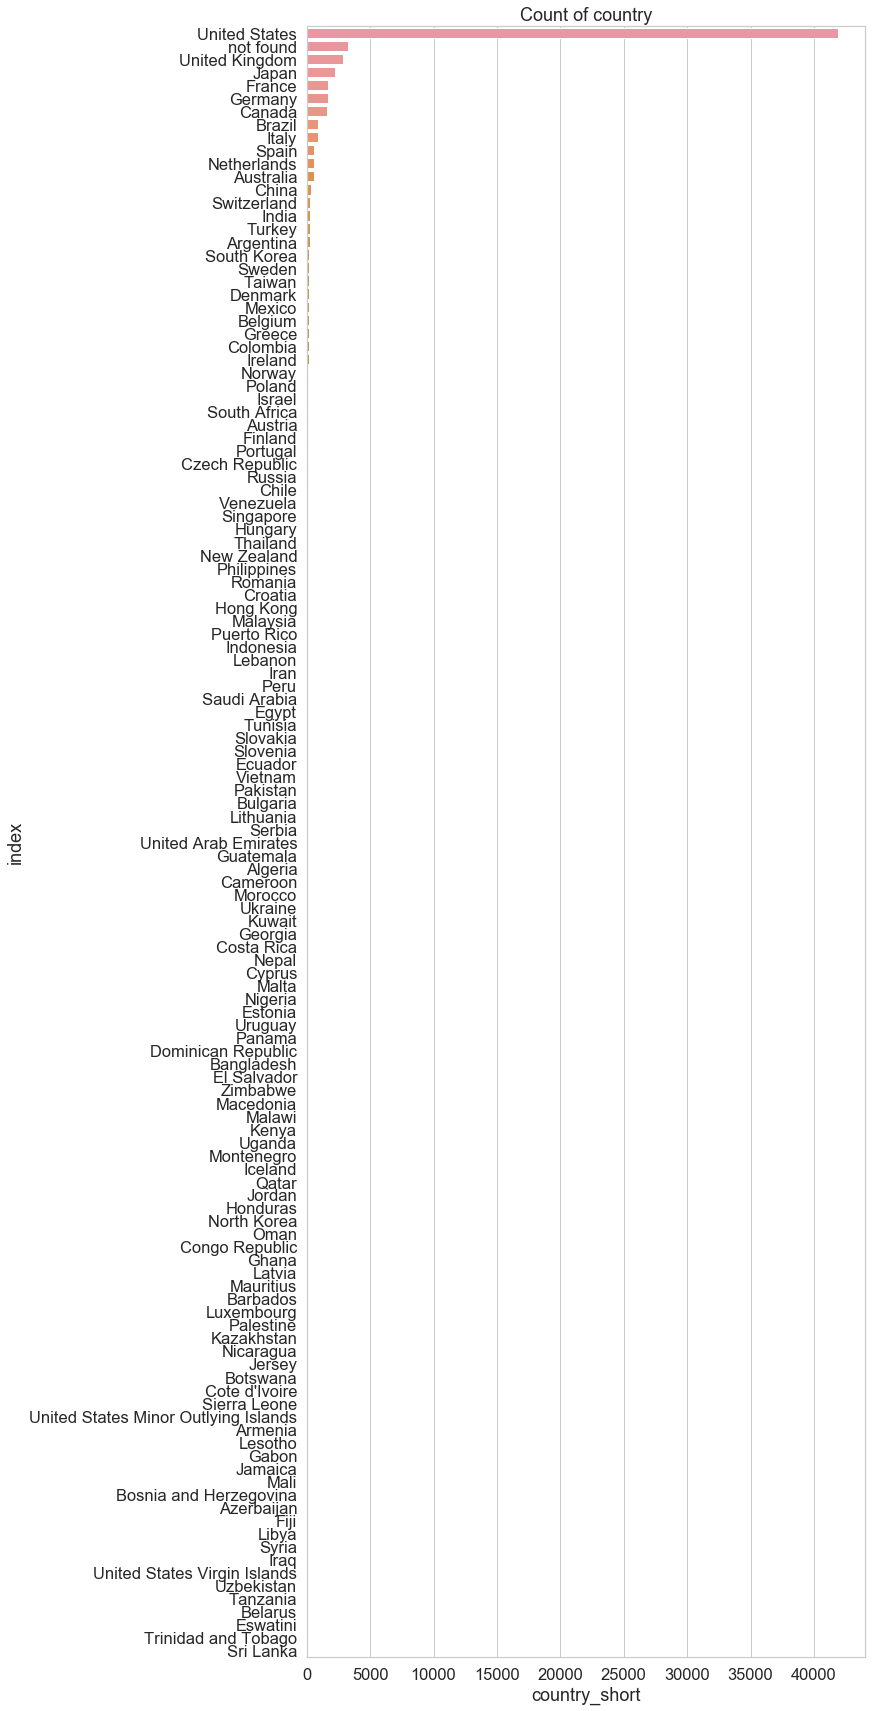

In [489]:
plt.figure(figsize=(20,10))
serious_pivot = data_subset[['country_short']+serious_flag].groupby(by='country_short').sum().reset_index().sort_values('seriousnesslifethreatening',ascending = False)
sns.set_color_codes("pastel")
g = sns.barplot(x = 'index', y = 'serious', 
                data = data_subset['serious'].value_counts('normalized').reset_index(), 
                hue ='index', alpha = 0.9);
new_title = 'Occurence frequency of serious adverse effects'
plt.title(new_title);
sns.despine(offset=10, trim=True);




plt.figure(figsize=(10,30))
sns.barplot(data = data_subset['country_short'].value_counts().reset_index(), x = 'country_short', y = 'index')
plt.title('Count of country');

#### Product Overview:


In [428]:
### Product overview:


print('There are '+ str(data_subset['medicinalproduct'].nunique()) + ' unique medicincal product in this dataset, and '+ str(data_subset['active_substance'].nunique()) +' types of active substance')


There are 6869 unique medicincal product in this dataset, and 1672 types of active substance


In [557]:
def get_sample_rank(data_subset,col,pivot_value = 'serious'):
    col_count = str(col)+'_count'
    if col_count in data_subset.columns:
        
        strat_sample = data_subset[(data_subset[col_count]>200) & (data_subset[col]!='None')].groupby(col).apply(lambda d: d.sample(100))


        strat_sample.reset_index(drop=True, inplace = True)

        return strat_sample.pivot_table(values=pivot_value, index=col).reset_index().sort_values(pivot_value,ascending=False)
    else:
        return None
    
def compile_bootstrap(data_subset,col,pivot_value = 'serious',n=100, plot = True):
    
    bootstrap_samples = pd.concat(Parallel(n_jobs= -1)(delayed(get_sample_rank)(data_subset=data_subset,col=col,pivot_value=pivot_value) for i in np.arange(0,n)))
    
    if plot:
        plt.figure(figsize=(20,20))
        sns.boxplot(data = bootstrap_samples,  y = col , x = pivot_value)
        plt.title('Rate of '+ pivot_value + ' occurence based on ' + str(n)+' bootstrap samples of 100')
        plt.ylabel(col)
        plt.xlabel('Bootstrap rate')
        fig_name = col+'_'+pivot_value+'_'+ str(n)
        plt.savefig('figures/'+fig_name+'.png')
    
    bootstrap_median = bootstrap_samples.groupby(by=col).median().reset_index()
    
    bootstrap_median.columns = [col,'median']

    bootstrap_var = bootstrap_samples.groupby(by=col).var().reset_index()
    
    bootstrap_var.columns = [col,'var']
    

    return bootstrap_median.merge(bootstrap_var).sort_values('median',ascending = False)

In [559]:
serious_flag

['serious',
 'seriousnesslifethreatening',
 'seriousnessdeath',
 'seriousnesshospitalization',
 'seriousnesscongenitalanomali',
 'seriousnessother',
 'seriousnessdisabling']

In [ ]:
active_substance_bootstrap = compile_bootstrap(data_subset=data_subset, col ='active_substance',pivot_value='seriousnessdeath',n=50)

In [561]:
active_substance_bootstrap

,active_substance,median,var
5,CINACALCET HYDROCHLORIDE,0.850,0.001085
6,CLOZAPINE,0.515,0.001294
20,RIVAROXABAN,0.465,0.001315
8,DARBEPOETIN ALFA,0.380,0.000739
4,CALCIUM CHLORIDE\DEXTROSE\MAGNESIUM CHLORIDE\S...,0.340,0.001820
1,ADALIMUMAB,0.325,0.002499
18,NATALIZUMAB,0.270,0.001135
2,APIXABAN,0.260,0.001129
0,ACETAMINOPHEN,0.250,0.001203
17,LENALIDOMIDE,0.250,0.001146


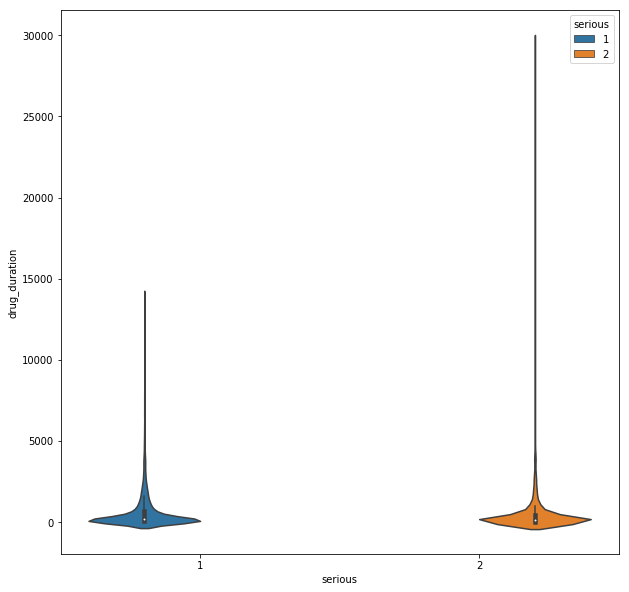

In [309]:
plt.figure(figsize=(10,10))
sdescribeolinplot(data= data_subset[data_subset['drug_duration']>10], x = 'serious', y = 'drug_duration', hue = 'serious' )


In [200]:
data_subset['active_substance'] = data_subset['active_substance'].fillna('UNKNOWN')

### Mapping adverse event rate across countries:
In order to visualize adverse events on a map, we need to standardize country names and get geocode (lat/lon), also, we'll only show countries that have at least 100 cases  

In [299]:
country_pivot = data_subset2[data_subset2['report_count']>100].pivot_table(values=serious_flags, columns=['country_short','lat','lon']).reset_index()

condition_summary = country_pivot[country_pivot['level_0']=='seriousnesslifethreatening']

condition_summary.columns = ['condition','country','lat','lon','proportion']


In [300]:
folium_map(data2 = condition_summary, title = 'Rate of life threatening adverse effects (countries with record > 100)')